# Inspect Training Data of Particles in X-ray Nano-tomography Images

Inspect and visualize data loading and pre-processing code.

## Data shuffling and split into train/val/test sub-datasts

In [1]:
import os
import sys
import json
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

In [3]:
dataset_dir = 'data/train'
annotations = json.load(open(os.path.join(dataset_dir, "via_export_json.json")))
annotations = list(annotations.values()) 
# Skip unannotated images.
annotations = [a for a in annotations if a['regions']]

print('Number of training set: ', len(annotations))

dataset_dir = 'data/val'
annotations = json.load(open(os.path.join(dataset_dir, "via_export_json.json")))
annotations = list(annotations.values())  
annotations = [a for a in annotations if a['regions']]

print('Number of validation set: ', len(annotations))

dataset_dir = 'data/test'
annotations = json.load(open(os.path.join(dataset_dir, "via_export_json.json")))
annotations = list(annotations.values()) 
annotations = [a for a in annotations if a['regions']]

print('Number of test set: ', len(annotations))


Number of training set:  113
Number of validation set:  63
Number of test set:  45


In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

sys.path.append(ROOT_DIR)  
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


from samples import particles 

%matplotlib inline 

Using TensorFlow backend.


## Configurations

Configurations are defined in particles.py

In [5]:
config = particles.ParticlesConfig()
ROOT_DIR = os.getcwd()
PARTICLE_DIR = os.path.join(ROOT_DIR, "data/")
config

## Dataset

In [6]:
# Load dataset
dataset = particles.ParticlesDataset()
dataset.load_particles(PARTICLE_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 113
Class Count: 2
  0. BG                                                
  1. particles                                         


## Display Samples

Load and display images and masks.

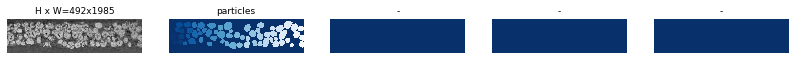

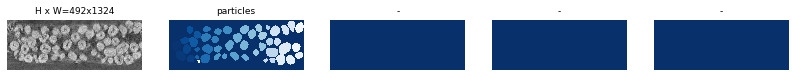

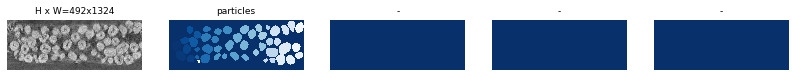

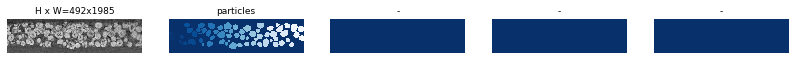

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  82 /home/lijz/LIBNet/data/train/xy0613.jpg
image                    shape: (492, 1324, 3)        min:    2.00000  max:  253.00000  uint8
mask                     shape: (492, 1324, 41)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (41,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (41, 4)               min:   42.00000  max: 1309.00000  int32


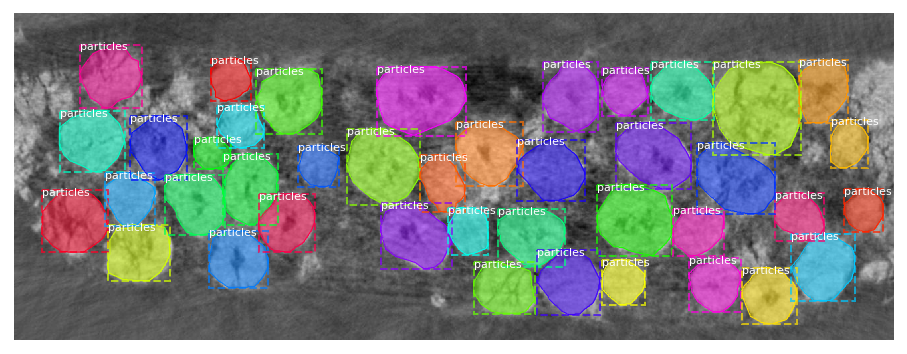

In [8]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  98 /home/lijz/LIBNet/data/train/xy0234.jpg
Original shape:  (492, 1324, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
mask                     shape: (1024, 1024, 27)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (27,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (27, 4)               min:   94.00000  max:  998.00000  int32


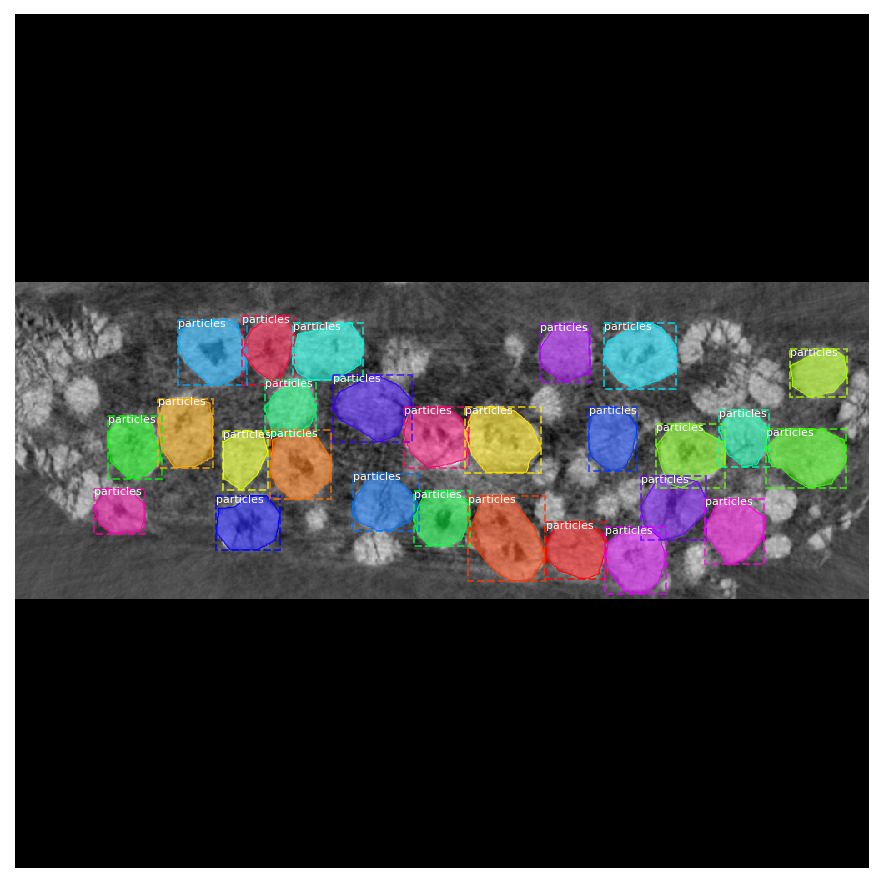

In [9]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

As we can see, some particles are quite hard to be labeled. Let's keep it as it is and see how the trained network performs.

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1985.00000  float64
class_ids                shape: (49,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (49, 4)               min:   11.00000  max: 1020.00000  int32
mask                     shape: (1024, 1024, 49)      min:    0.00000  max:    1.00000  bool


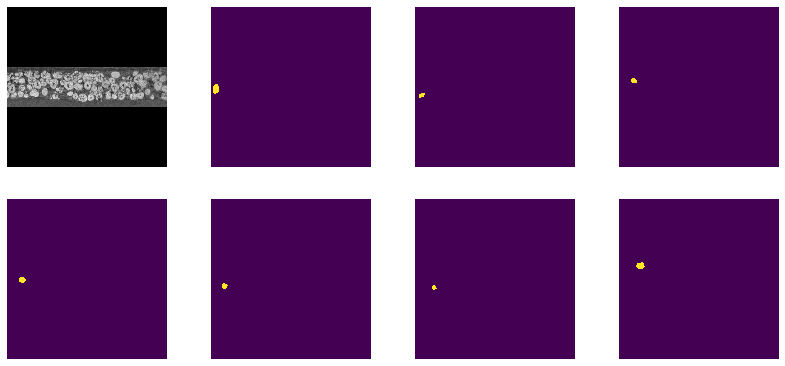

In [10]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

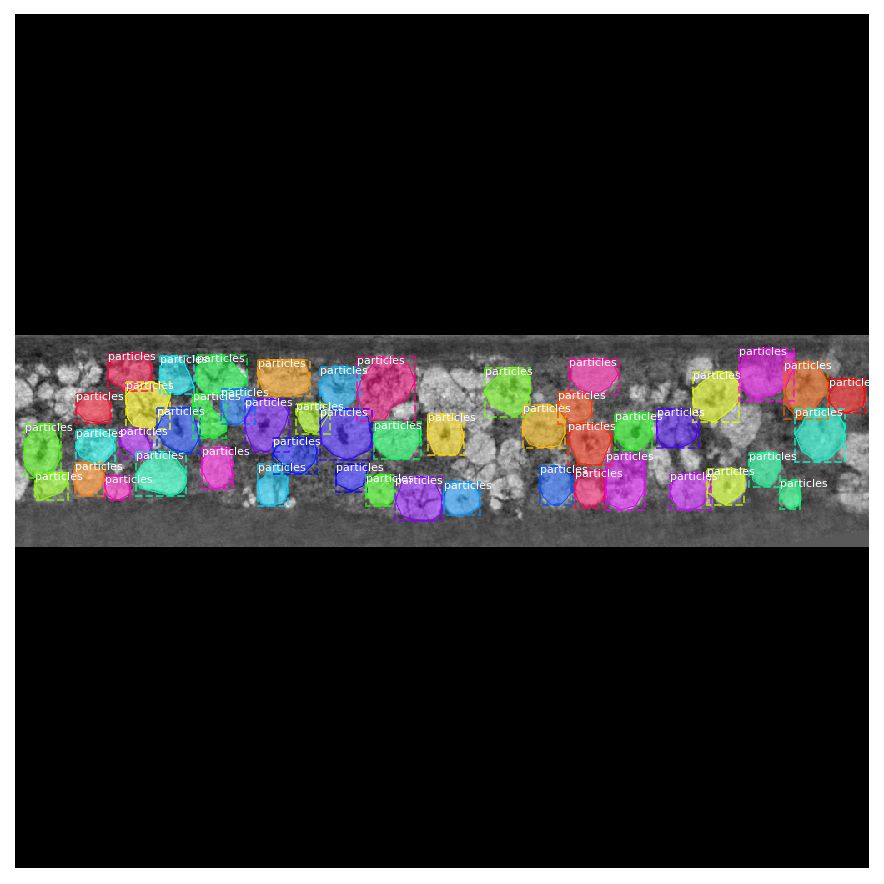

In [11]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 49)          min:    0.00000  max:    1.00000  bool


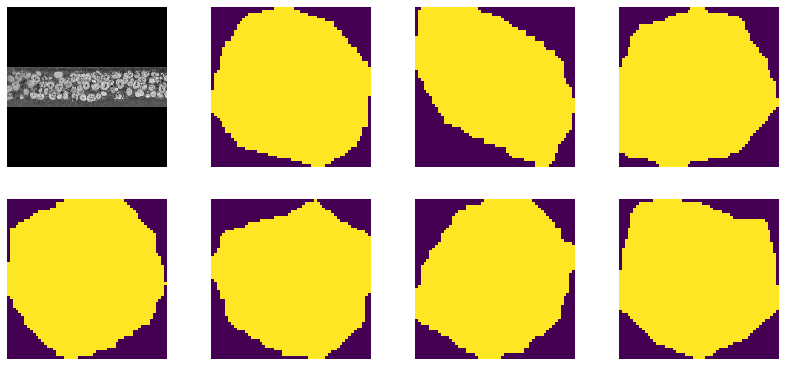

In [12]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

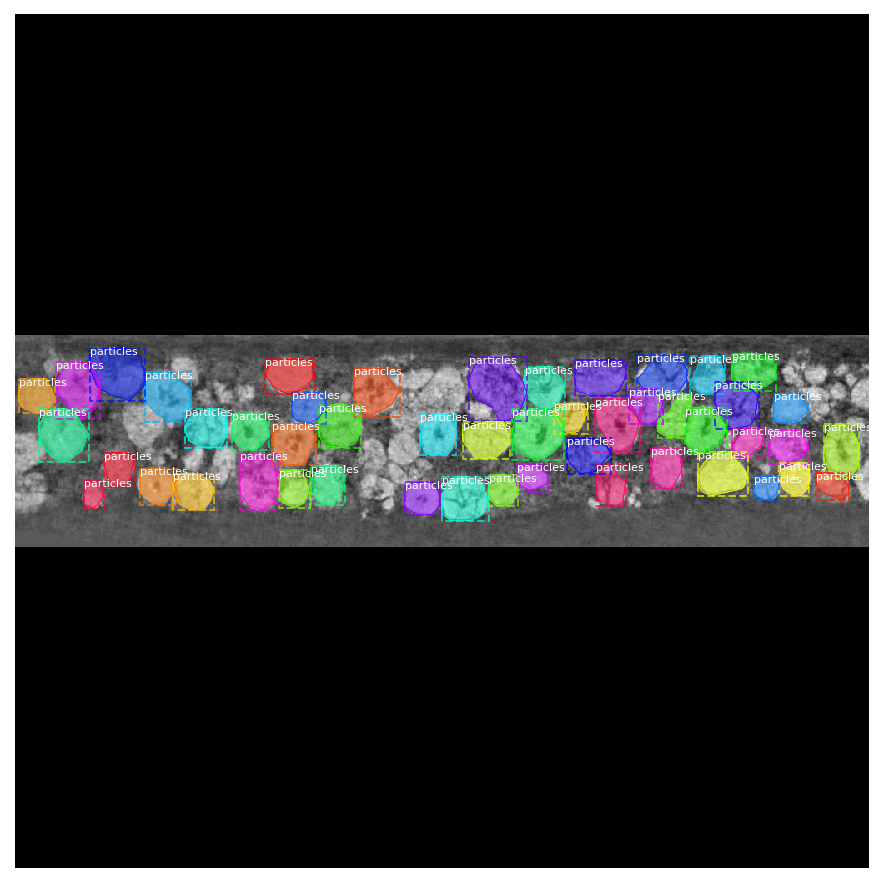

In [13]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)